In [1]:
from Utils.Solver import *

[*********************100%***********************]  5 of 5 completed

     pcost       dcost       gap    pres   dres
 0: -1.8611e-01 -1.2572e+00  1e+00  0e+00  3e+00
 1: -1.9288e-01 -2.5524e-01  6e-02  1e-16  2e-01
 2: -2.0804e-01 -2.1514e-01  7e-03  6e-17  4e-03
 3: -2.1116e-01 -2.1180e-01  6e-04  2e-16  1e-04
 4: -2.1163e-01 -2.1167e-01  4e-05  1e-16  4e-17
 5: -2.1167e-01 -2.1167e-01  7e-07  2e-16  2e-17
 6: -2.1167e-01 -2.1167e-01  7e-09  6e-17  2e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.16666654222276403), 'MSFT': np.float64(0.36666654183529257), 'TSLA': np.float64(3.711963517221946e-07), 'AMZN': np.float64(2.989759995410066e-09), 'GOOG': np.float64(0.46666654175583167)}
Final Portfolio Weights: [1.66666542e-01 3.66666542e-01 3.71196352e-07 2.98976000e-09
 4.66666542e-01]


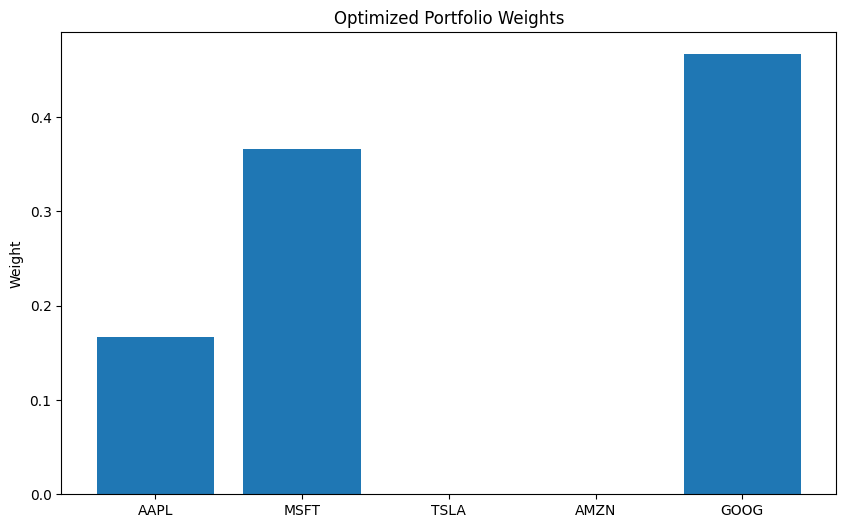

In [3]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

portfolio_solver = Portfolio_Solver(0.5, max_weight_threshold=0.3)
portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, signal_scores)
print("Final Portfolio Weights:", portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)



Total Portfolio Return: 142.57%
Annualized Portfolio Return: 34.36%


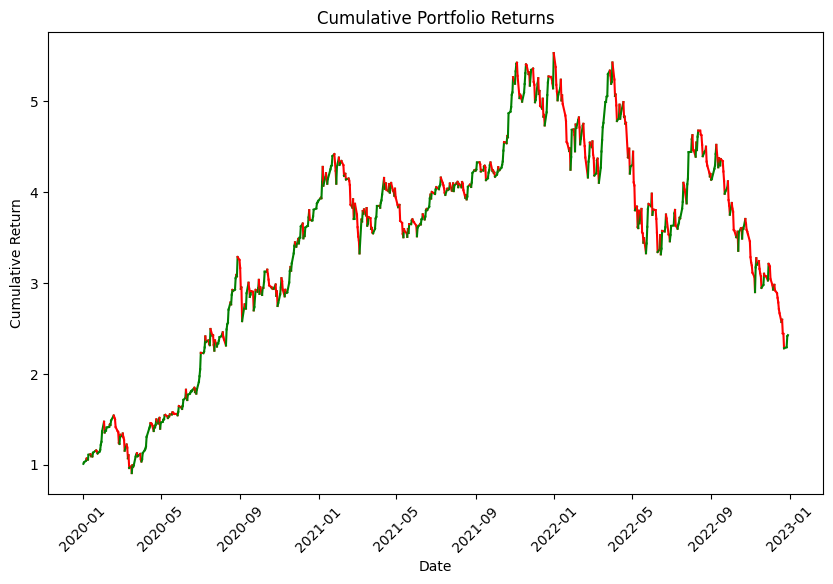

In [4]:
# Step 2: Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)

# Step 3: Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data)

## Signals 

In [5]:
import yfinance as yf
import talib as ta
import pandas as pd

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

print(data['Close'])
print(data['Close'].to_numpy().shape)
print(data['Close'].to_numpy().flatten())
print(data['Close'].to_numpy().flatten().shape)


[*********************100%***********************]  5 of 5 completed

Ticker            AAPL       AMZN       GOOG        MSFT        TSLA
Date                                                                
2020-01-02   72.716064  94.900497  68.046204  153.323242   28.684000
2020-01-03   72.009117  93.748497  67.712280  151.414124   29.534000
2020-01-06   72.582901  95.143997  69.381874  151.805481   30.102667
2020-01-07   72.241539  95.343002  69.338585  150.421387   31.270666
2020-01-08   73.403648  94.598503  69.884995  152.817352   32.809334
...                ...        ...        ...         ...         ...
2022-12-23  130.344482  85.250000  89.386620  234.405426  123.150002
2022-12-27  128.535522  83.040001  87.515495  232.667480  109.099998
2022-12-28  124.591377  81.820000  86.052422  230.281525  112.709999
2022-12-29  128.120361  84.180000  88.530678  236.644119  121.820000
2022-12-30  128.436661  84.000000  88.311714  235.475677  123.180000

[756 rows x 5 columns]
(756, 5)
[ 72.71606445  94.90049744  68.04620361 ...  88.31171417 235.47567749


In [6]:
import yfinance as yf
import talib as ta
import pandas as pd

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize empty lists to store results
rsi_list = []
macd_list = []
macd_signal_list = []
macd_hist_list = []

# Loop over tickers to calculate the indicators for each one separately
for ticker in tickers:
    # Get the close price for each ticker
    close = data['Close'][ticker].dropna()
    
    # Calculate RSI and MACD for each ticker
    rsi = ta.RSI(close.to_numpy(), timeperiod=14)
    macd, macd_signal, macd_hist = ta.MACD(close.to_numpy(), fastperiod=12, slowperiod=26, signalperiod=9)
    
    # Convert NumPy arrays to Pandas Series, and then append to the lists
    rsi_series = pd.Series(rsi, name=f'{ticker}_RSI')
    macd_series = pd.Series(macd, name=f'{ticker}_MACD')
    macd_signal_series = pd.Series(macd_signal, name=f'{ticker}_MACD_signal')
    macd_hist_series = pd.Series(macd_hist, name=f'{ticker}_MACD_hist')
    
    rsi_list.append(rsi_series)
    macd_list.append(macd_series)
    macd_signal_list.append(macd_signal_series)
    macd_hist_list.append(macd_hist_series)

# Concatenate the results across the columns (axis=1)
data['RSI'] = pd.concat(rsi_list, axis=1)
data['MACD'] = pd.concat(macd_list, axis=1)
data['MACD_signal'] = pd.concat(macd_signal_list, axis=1)
data['MACD_hist'] = pd.concat(macd_hist_list, axis=1)

# Check the results
print(data[['Close', 'RSI', 'MACD', 'MACD_signal']].tail())


[*********************100%***********************]  5 of 5 completed


ValueError: Cannot set a DataFrame with multiple columns to the single column RSI

In [ ]:
# Define a function to assign scores based on RSI
def rsi_score(rsi_value):
    if rsi_value < 30:
        return 1  # Strong buy signal
    elif rsi_value > 70:
        return -1  # Strong sell signal
    else:
        return 0  # Neutral signal

# Define a function to assign scores based on MACD
def macd_score(macd_value, macd_signal_value):
    if macd_value > macd_signal_value:
        return 1  # Bullish crossover
    elif macd_value < macd_signal_value:
        return -1  # Bearish crossover
    else:
        return 0  # No crossover

In [ ]:
data['RSI_Score'] = data['RSI'].apply(rsi_score)
print(data.columns)

data['Final_Score'] = data['RSI_Score'] + data['MACD_Score']


MultiIndex([(      'Close', 'AAPL'),
            (       'High', 'AAPL'),
            (        'Low', 'AAPL'),
            (       'Open', 'AAPL'),
            (     'Volume', 'AAPL'),
            (        'RSI',     ''),
            (       'MACD',     ''),
            ('MACD_signal',     ''),
            (  'MACD_hist',     ''),
            (  'RSI_Score',     '')],
           names=['Price', 'Ticker'])


KeyError: 'MACD_Score'